In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/bhawks/.conda/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

'export' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from tqdm import trange

# Load data, select ADC

In [9]:
wireplane = "V"
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
max_mels = 11000
min_edp = 50000
ADC_MIN = 3
ADC_MAX = 10
waveform_scaler = StandardScaler()

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

def extract_peak(data):
    #extract index of peak
    idx = np.array([data['stp0'], data['adc0'], data['stp1'], data['adc1'], data['stp2'], data['adc2'], data['stp3'], data['adc3'], data['stp4'], data['adc4']])
    #same as before
    return np.transpose(idx)

def extract_peak_info(data):
    peaks_pos = [data['stp0'], data['stp1'], data['stp2'], data['stp3'], data['stp4']]
    adcs = [data['adc0'], data['adc1'], data['adc2'], data['adc3'], data['adc4']]
    return np.array(peaks_pos).T, np.array(adcs).T

def extract_nel_info(data):
    nels = [data['nel0'], data['nel1'], data['nel2'], data['nel3'], data['nel4']]
    return np.array(nels).T

def extract_edp_info(data):
    edp = [data['edp0'], data['edp1'], data['edp2'], data['edp3'], data['edp4']]
    return np.array(edp).T

def filter_signals(data, clean_data, filter_adc_max=True):
    #edp_mask = np.all(extract_edp_info(data)>min_edp, axis = 1)
    #nel_mask = np.all(extract_nel_info(data)<max_mels, axis = 1)
    #pd.DataFrame(np.all(extract_edp_info(data)>min_edp, axis = 1)).describe()
    #print(edp_mask)
    #print(nel_mask)
    #filter_mask = nel_mask #np.logical_and(edp_mask,nel_mask) 
    filtered_data = data#[filter_mask]
    cln_filtered_data = clean_data#[filter_mask]
    
    filtered_peak = extract_peak_info(cln_filtered_data)[1]
    if filter_adc_max:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
        peak_mask &= np.any(filtered_peak<ADC_MAX, axis = 1)
    else:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
    
    filtered_data = filtered_data[peak_mask]
    cln_filtered_data = cln_filtered_data[peak_mask]
    
    return filtered_data, cln_filtered_data, filtered_peak

def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return raw_waveforms

In [10]:
#X = np.load("data/X_argoneut.npz")
#y = np.load("data/y_argoneut.npz")
#old_peak = np.load("peak_argoneut.npz")

#Load Training Data
path = "../../dunesnb/1dcnn/train/train/nu_cc/"
path2 = "../../dunesnb/1dcnn/train/train/nu_es/"
filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
clean_filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]
filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
clean_filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]

filenames =  filenames1+filenames2
clean_filenames = clean_filenames1+clean_filenames2

combined_data = np.concatenate([np.load(fname) for fname in filenames])
combined_clean_data = np.concatenate([np.load(fname) for fname in filenames])

noise_path = "../../dunesnb/1dcnn/train/train/noise/"
noise_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and sig_name in f)]
#print(noise_filenames)
noise_clean_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and cln_name in f)]

combined_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_filenames])
#print(combined_noise)
#combined_clean_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_clean_filenames])



In [11]:
combined_data.shape[0]

231744

# Train/Noise Data Preprocessing



In [12]:
from sklearn.utils import shuffle
print("Unfiltered:" + str(combined_data.shape[0]))
#Filter out tiny signals < ADC_MIN, but leave big signals to test on (> ADC_MAX)
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, False)
print("> ADC_MIN:" + str(combined_data.shape[0]))

#split train and test sets (~50k ea before filtering) 
combined_data, x_test_data, combined_clean_data, x_test_clean  = train_test_split(
    combined_data, combined_clean_data, test_size=0.5, shuffle=True
)
print("Train Split:" + str(combined_data.shape[0]))
#filter data and extract waveforms of filtered data
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, True)
signal_waveforms = get_std_waveforms(combined_data)
print("Train Split Filtered ADC_MIN < x < ADC_MAX:" + str(combined_data.shape[0]))
#extract waveforms of noise
noise_waveforms = get_std_waveforms(combined_noise)
#extract waveforms of test data
test_signal_waveforms = get_std_waveforms(x_test_data)
print("Test Set:" + str(test_signal_waveforms.shape[0]))

Unfiltered:231744
> ADC_MIN:130731
Train Split:65365
Train Split Filtered ADC_MIN < x < ADC_MAX:62239
Test Set:65366


In [13]:
print(test_signal_waveforms.shape, signal_waveforms.shape, noise_waveforms.shape)

(65366, 200) (62239, 200) (108600, 200)


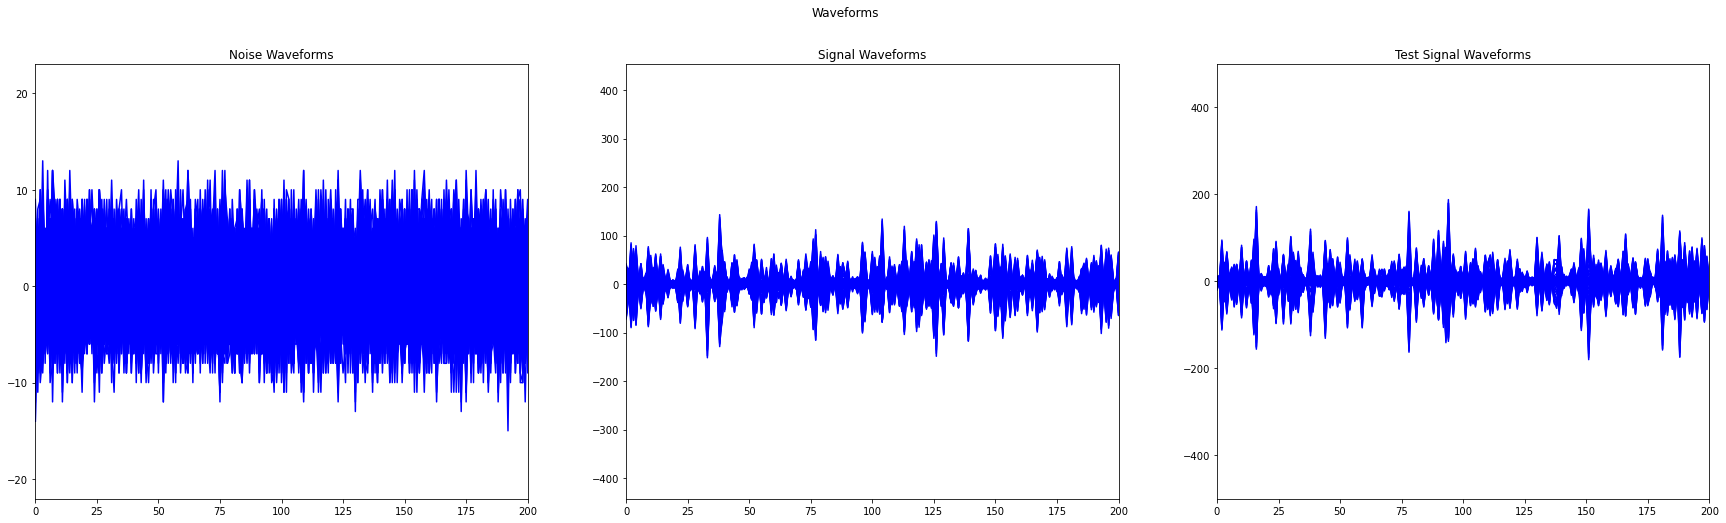

In [14]:
start_for_plot = 0
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('Waveforms')
ax1.plot(noise_waveforms,color='blue')
ax1.set_xlim(start_for_plot, start_for_plot + 200)
ax1.set_title("Noise Waveforms")

ax2.plot(signal_waveforms,color='blue')
ax2.set_xlim(start_for_plot, start_for_plot + 200)
ax2.set_title("Signal Waveforms")

ax3.plot(test_signal_waveforms,color='blue')
ax3.set_xlim(start_for_plot, start_for_plot + 200)
ax3.set_title("Test Signal Waveforms")
ax3.set_ybound(-500, 500)
plt.show()

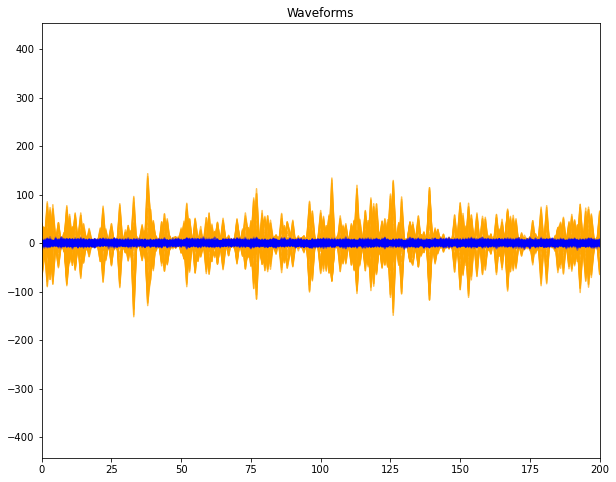

In [15]:
start_for_plot = 0
fig = plt.figure(figsize=(10, 8))
plt.plot(signal_waveforms,color='orange', alpha=0.7)
plt.plot(noise_waveforms,color='blue',alpha=0.3)
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("Waveforms")
plt.show()

In [16]:
#generate y data (assuming all radiologicals contain signal, all noise does not)
y_noise_full = np.zeros(noise_waveforms.shape[0])
y_signal = np.ones(signal_waveforms.shape[0])
y_test_signal = np.ones(test_signal_waveforms.shape[0])

# split test and train noise datasets (50k)
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(noise_waveforms, y_noise_full, test_size=0.5, shuffle=True)
#Shuffle signal waveforms to be safe
signal_waveforms, y_signal = shuffle(signal_waveforms,y_signal)
#Shuffle test waveformst to be safe
x_test, y_test = shuffle(test_signal_waveforms,y_test_signal)

In [17]:
print(x_noise_train.shape, signal_waveforms.shape, x_test.shape)

(54300, 200) (62239, 200) (65366, 200)


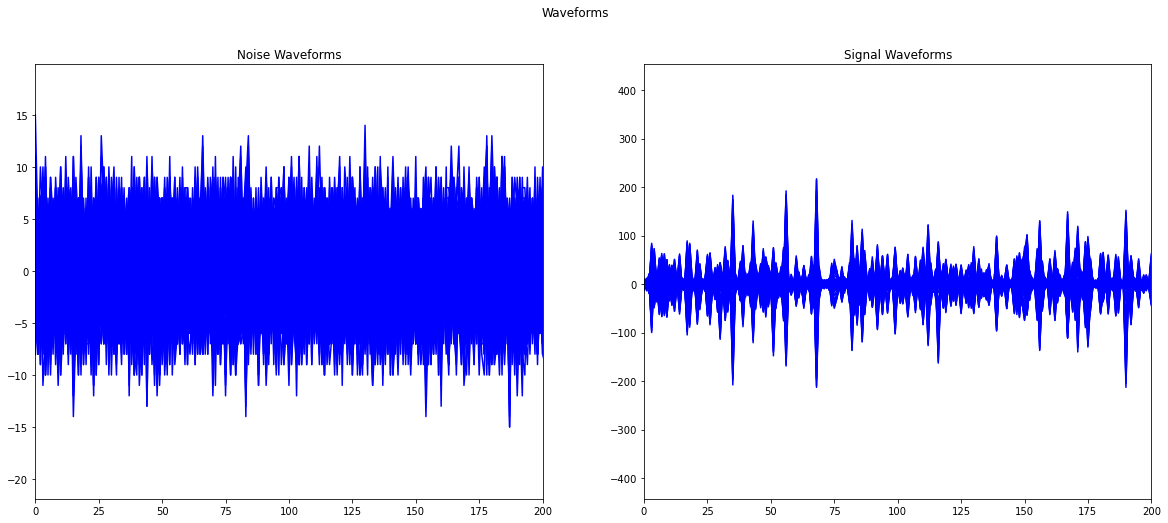

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Waveforms')
ax1.plot(x_noise_train, color='blue')
ax1.set_xlim(0, 200)
ax1.set_title("Noise Waveforms")

ax2.plot(signal_waveforms, color='blue')
ax2.set_xlim(0, 200)
ax2.set_title("Signal Waveforms")
plt.show()

In [19]:
#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced train set 
x_train = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], x_noise_train))
y_train = np.concatenate((y_signal[:int(x_noise_train.shape[0])], y_noise_train))
x_test = np.concatenate((x_test[:int(x_noise_test.shape[0])], x_noise_test))
y_test = np.concatenate((y_test_signal[:int(x_noise_test.shape[0])], y_noise_test))


# extra train shuffle for good measure 
x_train, y_train = shuffle(x_train,y_train)
# extra test shuffle for good measure 
x_test, y_test = shuffle(x_test,y_test)
#split train and valid sets (40k train 10k valid) 
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

In [20]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_valid.shape, y_valid.shape)

(86880, 200) (86880,) (108600, 200) (108600,) (21720, 200) (21720,)


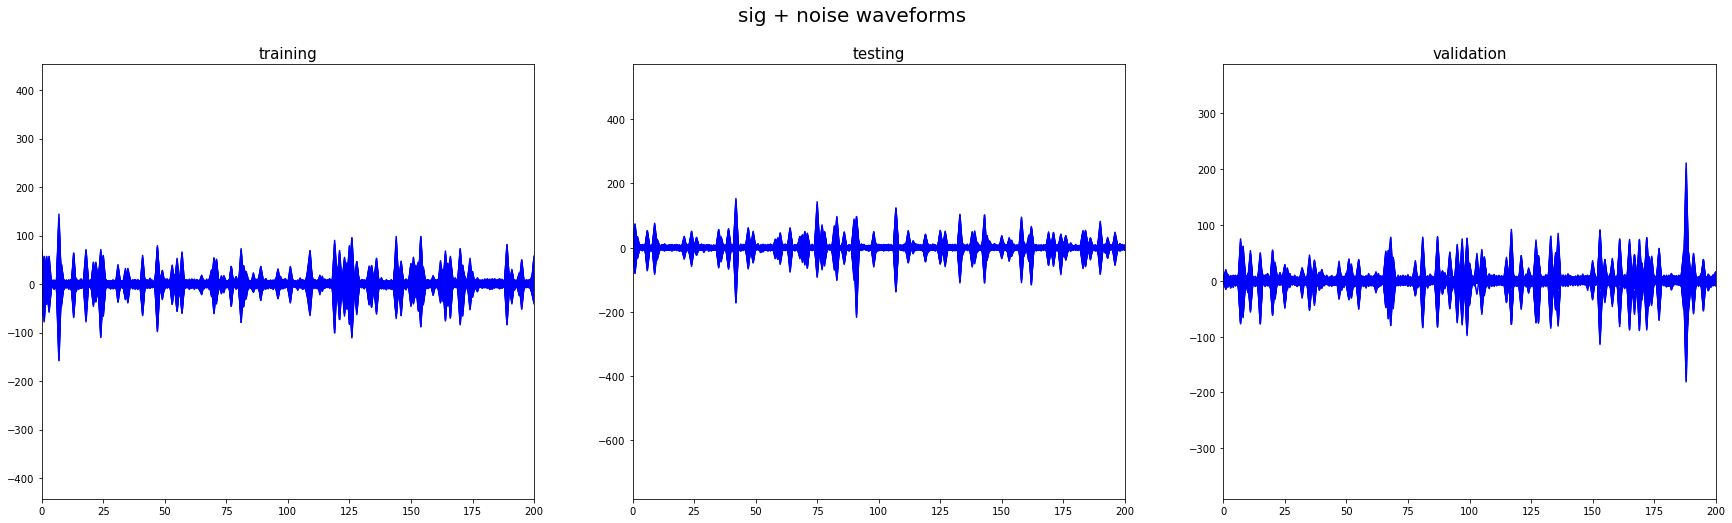

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('sig + noise waveforms',fontsize=20)
ax1.plot(x_train, color='blue')
ax1.set_xlim(0, 200)
ax1.set_title("training", fontsize=15)

ax2.plot(x_test, color='blue')
ax2.set_xlim(0, 200)
ax2.set_title("testing", fontsize=15)

ax3.plot(x_valid, color='blue')
ax3.set_xlim(0, 200)
ax3.set_title("validation", fontsize=15)
plt.show()

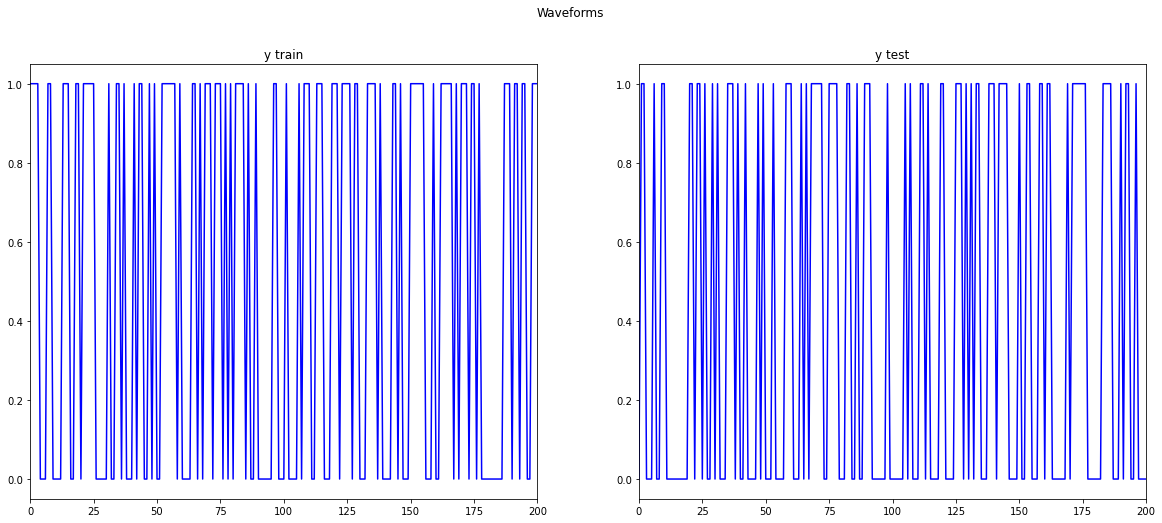

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Waveforms')
ax1.plot(y_train, color='blue')
ax1.set_xlim(0, 200)
ax1.set_title("y train")

ax2.plot(y_test, color='blue')
ax2.set_xlim(0, 200)
ax2.set_title("y test")
plt.show()

In [23]:
mean = x_train.mean()
std = x_train.std()

In [24]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std
#cc_x_test_scaled = (cc_x_test-mean)/std 
#es_x_test_scaled = (es_x_test-mean)/std 

In [25]:
print(x_train_scaled.shape, x_valid_scaled.shape, x_test_scaled.shape)

(86880, 200) (21720, 200) (108600, 200)


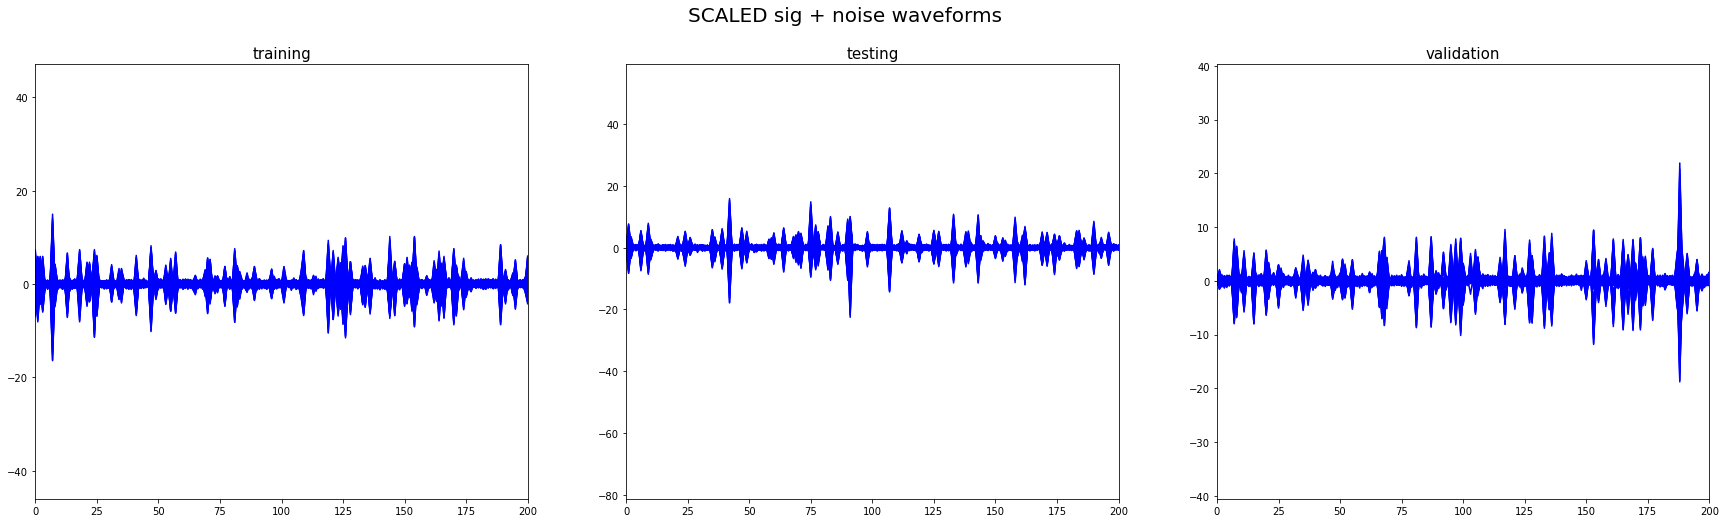

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('SCALED sig + noise waveforms',fontsize=20)
ax1.plot(x_train_scaled, color='blue')
ax1.set_xlim(0, 200)
ax1.set_title("training", fontsize=15)

ax2.plot(x_test_scaled, color='blue')
ax2.set_xlim(0, 200)
ax2.set_title("testing", fontsize=15)

ax3.plot(x_valid_scaled, color='blue')
ax3.set_xlim(0, 200)
ax3.set_title("validation", fontsize=15)
plt.show()

In [27]:
np.save("learn_models/mean_v_nu", mean)
np.save("learn_models/scale_v_nu", std)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

# 1D-CNN LArTPC Waveform Recognition

In [35]:
time_periods = 200
def create_model():
  model = Sequential()  
  #first convolutional block
  model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
  model.add(MaxPooling1D(pool_size=2))

  #second convolutional block
  model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.1))
  
  #third convolutional block
  model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2)) 
    
  model.add(Flatten())

  
 
  model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
  return model

x

In [30]:
model = create_model()

#lr=0.001
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 199, 16)           64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 48, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 24, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 64)            1

In [31]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

In [32]:
print(x_train_scaled.shape, x_valid_scaled.shape, x_test_scaled.shape)

(86880, 200, 1) (21720, 200, 1) (108600, 200, 1)


In [33]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


In [34]:
%%time
history = model.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=100,
                         
                    callbacks=[earlystop],                      
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)   

Epoch 1/100


ValueError: in user code:

    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 400, 1), found shape=(None, 200, 1)


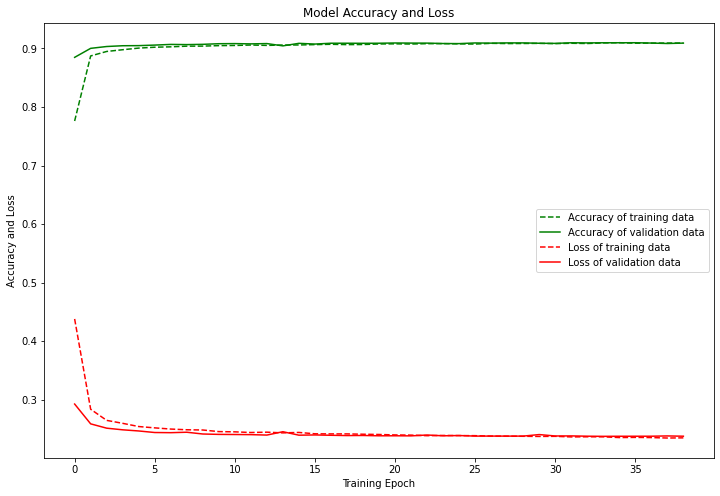

In [34]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [35]:
#del x_train

import gc
gc.collect()

5305

In [36]:
model.save("learn_models/" + wireplane + "plane_nu.h5")

In [37]:
model.evaluate(x_test_scaled, y_test, batch_size=4096)

27/27 [==============================] - 0s 9ms/step - loss: 0.2283 - accuracy: 0.9135


[0.2282889187335968, 0.9135082960128784]

In [38]:
#model.evaluate(es_x_test_scaled, es_y_test, batch_size=4096)

In [38]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


# Train

In [39]:
%%time
%matplotlib inline
import seaborn as sns
infer = model.predict(x_train_, batch_size=4096)

22/22 [==============================] - 0s 15ms/step
Wall time: 665 ms


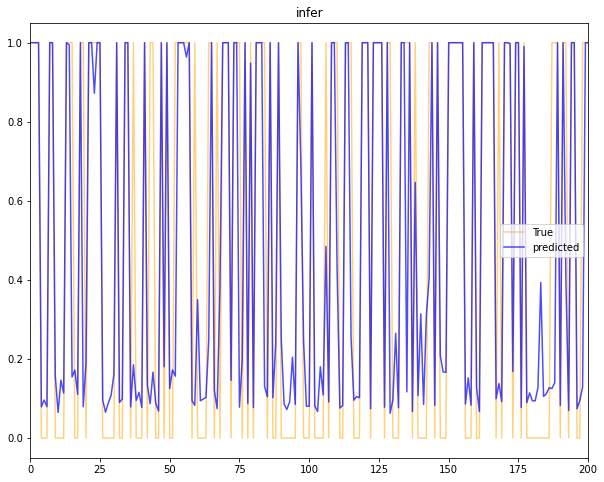

In [55]:
start_for_plot = 0
fig = plt.figure(figsize=(10, 8))
plt.plot(y_train,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [57]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_, infer)
auc_keras = auc(fpr_keras, tpr_keras)

In [58]:
print(auc_keras)

0.9523455945865298


In [59]:
np.save("learn_results/false_positive_V_train", fpr_keras)
np.save("learn_results/true_positive_V_train", tpr_keras)
np.save("learn_results/thresholds_V_train", thresholds_keras)

# Valid

In [60]:
%%time
infer = model.predict(x_valid_, batch_size=4096)

6/6 [==============================] - 0s 21ms/step
Wall time: 173 ms


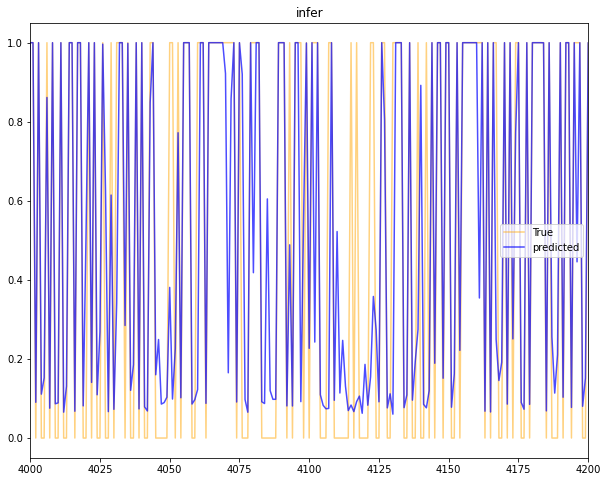

In [66]:
start_for_plot = 4000
fig = plt.figure(figsize=(10, 8))
plt.plot(y_valid_,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [67]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_valid_, infer)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.9463105531823891


In [68]:
np.save("learn_results/false_positive_" + wireplane + "_train", fpr_keras)
np.save("learn_results/true_positive_" + wireplane + "_train", tpr_keras)
np.save("learn_results/thresholds_" + wireplane + "_train", thresholds_keras)

In [37]:
plt.plot(fpr_keras, tpr_keras)
plt.title("ROC Curve - Validation Dataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

NameError: name 'fpr_keras' is not defined

# test

In [70]:
#%%time
#cc_infer = model.predict(cc_x_test_scaled, batch_size=4096)
#es_infer = model.predict(es_x_test_scaled, batch_size=4096)
all_infer = model.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test


27/27 [==============================] - 0s 5ms/step


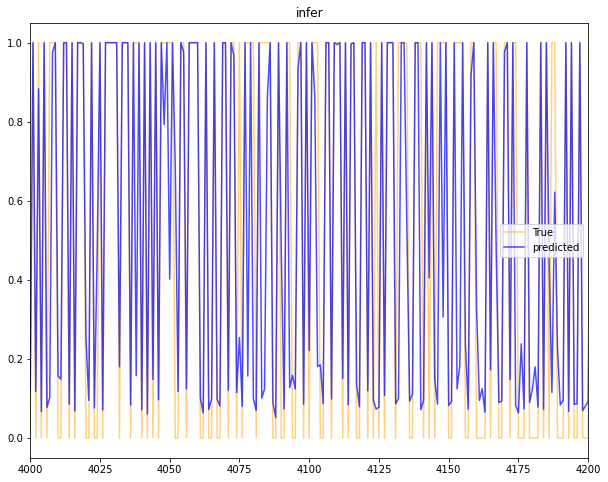

In [71]:
start_for_plot = 4000
fig = plt.figure(figsize=(10, 8))
plt.plot(all_y_test,color='orange',alpha=0.5, label='True')
plt.plot(all_infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

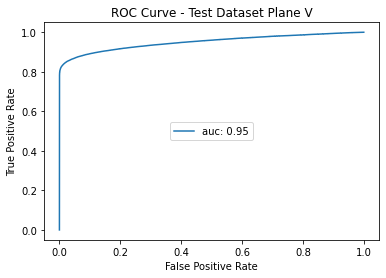

In [86]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc(fpr_keras, tpr_keras), 3)))
plt.title("ROC Curve - Test Dataset Plane " + wireplane )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

In [87]:
np.save("learn_results/false_positive_" + wireplane + "_valid", fpr_keras)
np.save("learn_results/true_positive_" + wireplane + "_valid", tpr_keras)
np.save("learn_results/thresholds_" + wireplane + "_valid", thresholds_keras)

In [88]:
%%time
all_infer_noise = model.predict(x_test_scaled[y_test==0], batch_size=4096)

14/14 [==============================] - 0s 18ms/step
Wall time: 377 ms


NameError: name 'all_infer_noise' is not defined